In [6]:
!pip install --upgrade transformers datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import re
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"🔥 GPU Available: {torch.cuda.is_available()}")

✅ All libraries imported successfully!
🔥 GPU Available: False


In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

urdu_digits = {"0": "۰", "1": "۱", "2": "۲", "3": "۳", "4": "۴",
               "5": "۵", "6": "۶", "7": "۷", "8": "۸", "9": "۹"}

def random_amount(min_amt=100, max_amt=90000):
    amt = random.randint(min_amt, max_amt)
    if random.random() < 0.7:
        return ''.join(urdu_digits[d] for d in str(amt))
    return str(amt)

def random_account():
    last4 = ''.join(random.choice("0123456789") for _ in range(4))
    prefix = random.choice([
        "AC", "A/C", "Acc", "Account", "A-C",
        "اکاؤنٹ", "اکاونٹ", "Khata", "کھاتہ", "Kh.", "KHATA"
    ])
    return f"{prefix} **{last4}"

def advanced_noise(text):
    noise_ops = [
        lambda t: t + random.choice(["!", "!!", "۔", ".", ""]),
        lambda t: " " + t,
        lambda t: t.replace(" ", "  "),
        lambda t: t.replace("Rs", random.choice(["Rs", "Rs.", "RS", "روپے", "rs"])),
        lambda t: t.replace("Payment", random.choice(["Payment", "Pyment", "پیمنٹ", "paymnt"])),
        lambda t: t.lower() if random.random() < 0.1 else t,
        lambda t: t.upper() if random.random() < 0.05 else t,
        lambda t: t
    ]
    return random.choice(noise_ops)(text)

def inject_spelling_mistakes(text):
    common_typos = {
        "ادائیگی": ["اداءیگی", "ادائگی", "اداٸیگی", "adaygi"],
        "ٹرانسفر": ["ٹرانسفرر", "ٹرانزفر", "transfer", "transfr"],
        "پیمنٹ": ["پیمٹ", "پیمینٹ", "payment", "pyment"],
        "اکاؤنٹ": ["اکاونٹ", "اکاٶنٹ", "khata", "acount"],
        "بل": ["بیل", "بُل", "bill"],
        "فیس": ["فیےس", "فییس", "fees"],
        "خرچہ": ["kharcha", "kharacha"]
    }

    for correct, wrongs in common_typos.items():
        if correct in text and random.random() < 0.25:
            text = text.replace(correct, random.choice(wrongs))

    return text
categories = {
    "ATM_Transfer": [
        "ATM سے {amt} نکلوا لئے گئے۔",
        "{acc} سے ATM نکلوا گئے: Rs {amt}.",
        "ATM ٹرانزیکشن مکمل: {amt}۔",
        "Cash nikala gaya: {amt}.",
        "ATM se paisay niklay: {amt}."
    ],

    "Bill_Payment": [
        "آپ کا بل {amt} ادا ہوگیا۔",
        "Bill jama hogaya: {amt}.",
        "بل ادا کر دیا گیا: {amt}.",
        "Utility bill paid {amt}.",
        "Bil ki ادائیگی مکمل: {amt}"
    ],

    "Education": [
        "School fee jama hogayi: {amt}.",
        "فیس جمع ہوئی: {amt}۔",
        "College ki fee deduct hui: {amt}.",
        "تعلیمی فیس ادا کی گئی: {amt}."
    ],

    "Entertainment": [
        "Netflix subscription: {amt}.",
        "Cinema ticket: {amt}.",
        "Gaming payment: {amt}.",
        "تفریحی خرچہ: {amt}.",
        "Movie booking: {amt}"
    ],

    "Fuel": [
        "پیٹرول بھروایا: {amt} روپے۔",
        "Fuel refill {amt}.",
        "Petrol pump: {amt}.",
        "Diesel refill: {amt}.",
        "Fuel kharcha: {amt}"
    ],

    "Groceries": [
        "کریانہ خریداری: {amt}۔",
        "Grocery expense: {amt}.",
        "Superstore: {amt}.",
        "Market se kharidari: {amt}.",
        "Grocery bill {amt}."
    ],

    "Healthcare": [
        "Pharmacy bill {amt}.",
        "میڈیکل خریداری: {amt}۔",
        "Hospital charges: {amt}.",
        "Lab test {amt}.",
        "دوائی خریدی گئی: {amt}"
    ],

    "Restaurant": [
        "Restaurant bill: {amt}.",
        "کھانے کا بل: {amt}۔",
        "Food order {amt}.",
        "Dinner kharcha: {amt}.",
        "Food bill paid {amt}."
    ],

    "Utilities": [
        "بجلی کا بل: {amt}.",
        "پانی کا بل ادا ہوا: {amt}.",
        "Gas bill: {amt}.",
        "Utility charges: {amt}.",
        "Meter bill {amt}"
    ],

    "Others": [
        "Transaction: {amt}.",
        "General debit: {amt}.",
        "Misc payment {amt}.",
        "Amount processed: {amt}.",
        "رقم منتقل: {amt}"
    ]
}

for k in list(categories.keys()):
    base = categories[k]
    variants = []
    for t in base:
        variants.append(t)
        variants.append("تفصیل: " + t)
        variants.append(t.replace("Rs ", "Rs. "))
        variants.append(t.replace(".", ""))
        variants.append(t + " براہ مہربانی تصدیق کریں۔")
        variants.append("Info: " + t)
    categories[k] = list(dict.fromkeys(variants))

def generate_synthetic_example(template):
    text = template.format(amt=random_amount(), acc=random_account())

    if random.random() < 0.20:
        text = text.replace("payment", "ادائیگی")

    text = inject_spelling_mistakes(text)
    text = advanced_noise(text)

    return text

def generate_dataset(n=20000, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    rows = []
    cats = list(categories.keys())
    per_class = max(1, n // len(cats))

    for cat in cats:
        templates = categories[cat]
        for _ in range(per_class):
            t = random.choice(templates)
            msg = generate_synthetic_example(t)
            rows.append({"SMS_Text": msg, "Category": cat})

    while len(rows) < n:
        cat = random.choice(cats)
        t = random.choice(categories[cat])
        rows.append({"SMS_Text": generate_synthetic_example(t), "Category": cat})

    return pd.DataFrame(rows).sample(frac=1, random_state=seed).reset_index(drop=True)

print("\n🔄 Generating Urdu-focused dataset...")
df_large = generate_dataset(100000)
print(f"Generated: {df_large.shape}")

print("\n📊 Category Distribution:")
print(df_large["Category"].value_counts())

df_large.to_csv("synthetic_urdu_enhanced.csv", index=False, encoding="utf-8-sig")
print("\n💾 Saved as synthetic_urdu_enhanced.csv")



🔄 Generating Urdu-focused dataset...
Generated: (100000, 2)

📊 Category Distribution:
Category
Restaurant       10000
Utilities        10000
Bill_Payment     10000
Others           10000
Healthcare       10000
Groceries        10000
Education        10000
Fuel             10000
ATM_Transfer     10000
Entertainment    10000
Name: count, dtype: int64

💾 Saved as synthetic_urdu_enhanced.csv


In [4]:
def advanced_clean_text(text):
    #  Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    #  Normalize Urdu digits to English (optional but helps models)
    urdu_digit_map = str.maketrans("۰۱۲۳۴۵۶۷۸۹", "0123456789")
    text = text.translate(urdu_digit_map)

    #  Normalize account formats → ACCOUNT
    text = re.sub(r'(A/C|AC|Acc|Account|A-C|اکاؤنٹ)\s*\**\d+', 'ACCOUNT', text, flags=re.I)

    #  Normalize masked accounts like **1234 or XX1234
    text = re.sub(r'(\*\*\d+|XX\d+)', 'ACCOUNT', text, flags=re.I)

    #  Normalize "Rs" formats (Urdu or English)
    text = re.sub(r'(Rs\.?|rs\.?|روپے|روپیے)', 'Rs', text)

    #  Normalize extra punctuation repeats (!!, ... , ۔۔)
    text = re.sub(r'[!۔]{2,}', '.', text)

    #  Urdu full stop to normal dot
    text = text.replace("۔", ".")

    return text.strip()


In [5]:
df_large['SMS_Text_Clean'] = df_large['SMS_Text'].apply(advanced_clean_text)

label_encoder = LabelEncoder()
df_large['Label'] = label_encoder.fit_transform(df_large['Category'])

print("\n📝 Categories:", list(label_encoder.classes_))

X = df_large['SMS_Text_Clean']
y = df_large['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\n✂️ Train size: {len(X_train)}, Test size: {len(X_test)}")



📝 Categories: ['ATM_Transfer', 'Bill_Payment', 'Education', 'Entertainment', 'Fuel', 'Groceries', 'Healthcare', 'Others', 'Restaurant', 'Utilities']

✂️ Train size: 80000, Test size: 20000


In [6]:
import time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score

print("\n Training Optimized Urdu/Roman Urdu Models...")

tfidf = TfidfVectorizer(
    max_features=12000,         # more capacity for mixed-language text
    ngram_range=(1, 3),         # catches Urdu patterns better
    min_df=2,
    max_df=0.97,
    sublinear_tf=True,
    token_pattern=r"(?u)\b\w+\b"  # ensures Urdu tokens are kept
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("\n Training Random Forest...")
start = time.time()

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,             # allow full learning
    min_samples_split=3,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f" Random Forest - Acc: {rf_acc:.4f}, F1: {rf_f1:.4f} ({time.time()-start:.1f}s)")

print("\n⚡ Training Linear SVM...")
start = time.time()

svm_model = LinearSVC(C=1.0, dual=False)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print(f" Linear SVM - Acc: {svm_acc:.4f}, F1: {svm_f1:.4f} ({time.time()-start:.1f}s)")

# Probability calibration for ensemble
svm_calibrated = CalibratedClassifierCV(svm_model, method="sigmoid", cv=3)
svm_calibrated.fit(X_train_tfidf, y_train)

print("\n Training Naive Bayes...")
start = time.time()

nb_model = MultinomialNB(alpha=0.05)
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

nb_acc = accuracy_score(y_test, y_pred_nb)
nb_f1 = f1_score(y_test, y_pred_nb, average='weighted')

print(f" Naive Bayes - Acc: {nb_acc:.4f}, F1: {nb_f1:.4f} ({time.time()-start:.1f}s)")

print("\n Training Soft Voting Ensemble...")
start = time.time()

lr_model = LogisticRegression(max_iter=1500, n_jobs=-1)

ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('svm', svm_calibrated),
        ('lr', lr_model),
        ('nb', nb_model)
    ],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train_tfidf, y_train)
y_pred_ensemble = ensemble.predict(X_test_tfidf)

ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='weighted')

print(f" Ensemble - Acc: {ensemble_acc:.4f}, F1: {ensemble_f1:.4f} ({time.time()-start:.1f}s)")



 Training Optimized Urdu/Roman Urdu Models...

 Training Random Forest...
 Random Forest - Acc: 1.0000, F1: 1.0000 (17.3s)

⚡ Training Linear SVM...
 Linear SVM - Acc: 1.0000, F1: 1.0000 (6.3s)

 Training Naive Bayes...
 Naive Bayes - Acc: 1.0000, F1: 1.0000 (0.1s)

 Training Soft Voting Ensemble...
 Ensemble - Acc: 1.0000, F1: 1.0000 (33.5s)


In [7]:
from sklearn.metrics import classification_report

print("\n" + "="*50)
print("📊 DETAILED EVALUATION RESULTS")
print("="*50)

models = {
    'Random Forest': y_pred_rf,
    'Linear SVM': y_pred_svm,
    'Naive Bayes': y_pred_nb,
    'Ensemble': y_pred_ensemble
}

for model_name, predictions in models.items():
    print("\n" + "-"*50)
    print(f"📌 {model_name} Classification Report")
    print("-"*50)

    print(classification_report(
        y_test,
        predictions,
        target_names=label_encoder.classes_,
        zero_division=0
    ))



📊 DETAILED EVALUATION RESULTS

--------------------------------------------------
📌 Random Forest Classification Report
--------------------------------------------------
               precision    recall  f1-score   support

 ATM_Transfer       1.00      1.00      1.00      2000
 Bill_Payment       1.00      1.00      1.00      2000
    Education       1.00      1.00      1.00      2000
Entertainment       1.00      1.00      1.00      2000
         Fuel       1.00      1.00      1.00      2000
    Groceries       1.00      1.00      1.00      2000
   Healthcare       1.00      1.00      1.00      2000
       Others       1.00      1.00      1.00      2000
   Restaurant       1.00      1.00      1.00      2000
    Utilities       1.00      1.00      1.00      2000

     accuracy                           1.00     20000
    macro avg       1.00      1.00      1.00     20000
 weighted avg       1.00      1.00      1.00     20000


--------------------------------------------------
📌 L


💾 Confusion matrices saved as 'confusion_matrices_all_models.png'


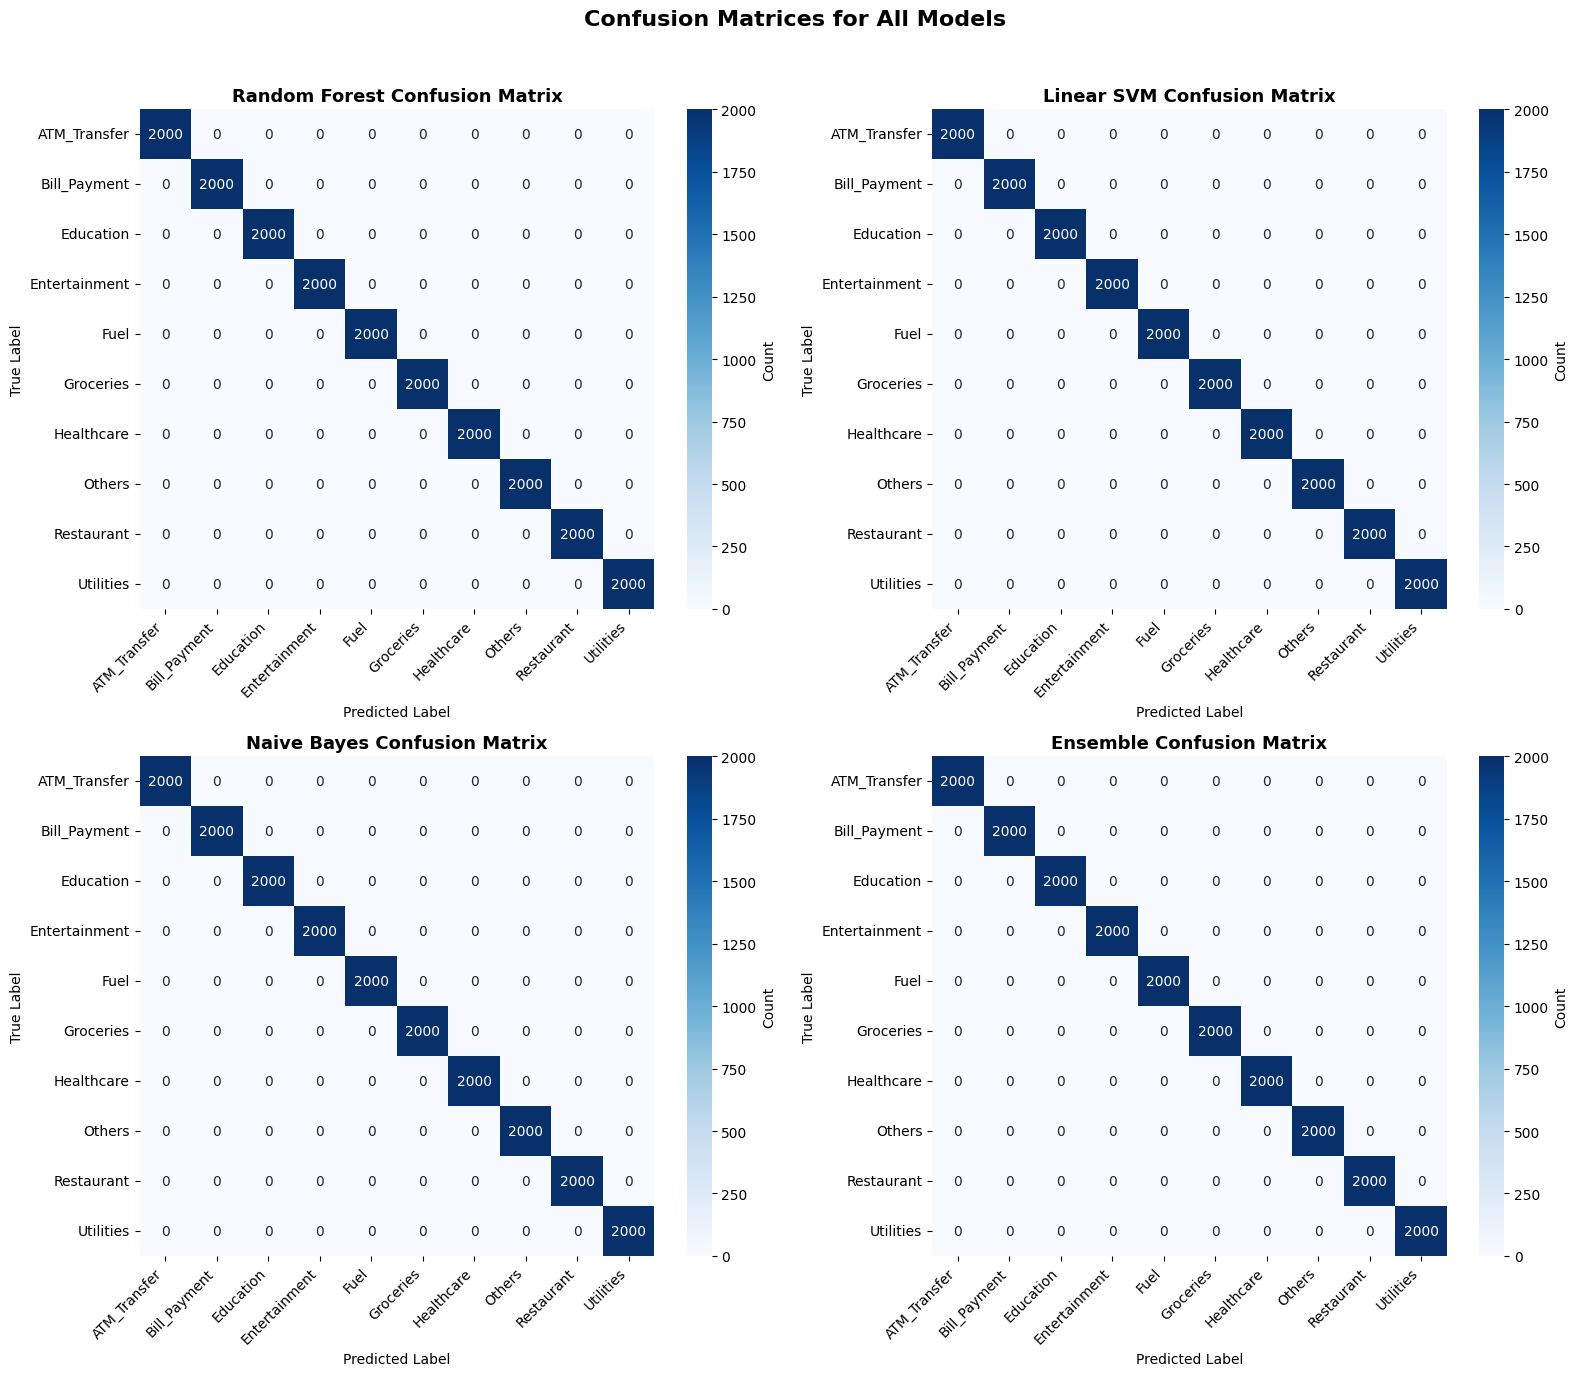

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Updated model prediction dictionary
models = {
    'Random Forest': y_pred_rf,
    'Linear SVM': y_pred_svm,      # Updated name
    'Naive Bayes': y_pred_nb,
    'Ensemble': y_pred_ensemble
}

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')

for idx, (model_name, predictions) in enumerate(models.items()):
    ax = axes[idx // 2, idx % 2]

    cm = confusion_matrix(y_test, predictions)

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        ax=ax,
        cbar_kws={'label': 'Count'}
    )

    ax.set_title(f'{model_name} Confusion Matrix', fontsize=13, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax.get_yticklabels(), rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.96])   # Keep space for suptitle
plt.savefig('confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')

print("\n💾 Confusion matrices saved as 'confusion_matrices_all_models.png'")



📈 Model Comparison:
        Model  Accuracy  F1-Score
Random Forest       1.0       1.0
          SVM       1.0       1.0
  Naive Bayes       1.0       1.0
     Ensemble       1.0       1.0
💾 Model comparison saved as 'model_comparison.png'

✅ Advanced model training complete!
🏆 Best Model: Random Forest


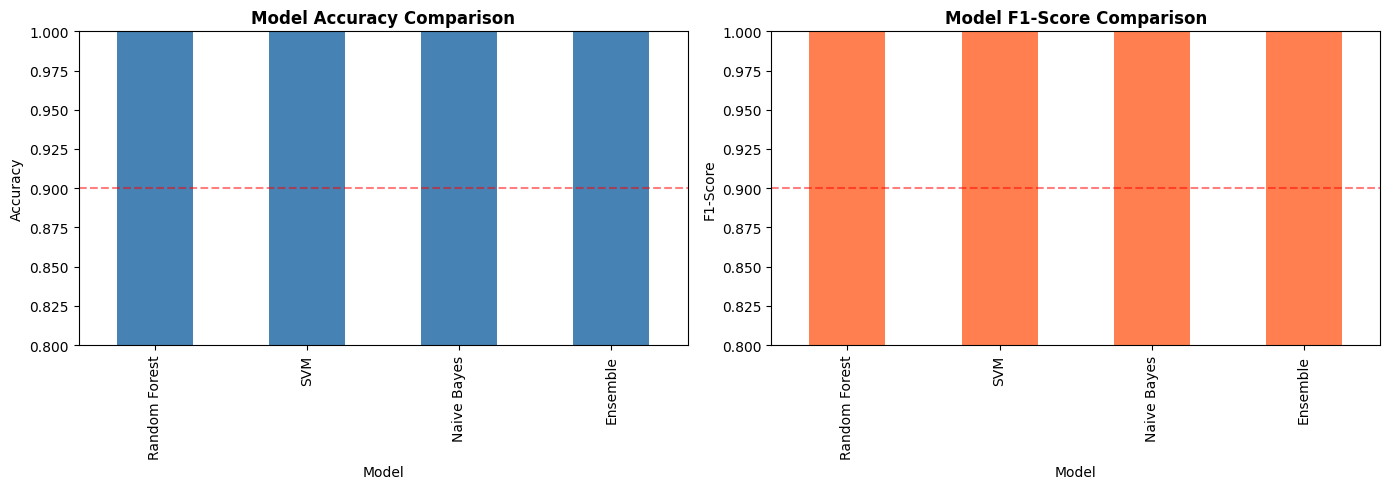

In [9]:
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Naive Bayes', 'Ensemble'],
    'Accuracy': [rf_acc, svm_acc, nb_acc, ensemble_acc],
    'F1-Score': [rf_f1, svm_f1, nb_f1, ensemble_f1]
})

print("\n📈 Model Comparison:")
print(results_df.to_string(index=False))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

results_df.plot(x='Model', y='Accuracy', kind='bar', ax=ax[0], color='steelblue', legend=False)
ax[0].set_title('Model Accuracy Comparison', fontweight='bold')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0.8, 1.0])
ax[0].axhline(y=0.9, color='r', linestyle='--', alpha=0.5)

results_df.plot(x='Model', y='F1-Score', kind='bar', ax=ax[1], color='coral', legend=False)
ax[1].set_title('Model F1-Score Comparison', fontweight='bold')
ax[1].set_ylabel('F1-Score')
ax[1].set_ylim([0.8, 1.0])
ax[1].axhline(y=0.9, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("💾 Model comparison saved as 'model_comparison.png'")

print("\n✅ Advanced model training complete!")
print(f"🏆 Best Model: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']}")

In [10]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

In [11]:
print(" Starting Advanced mBERT Training")
print(f" GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   Device: {torch.cuda.get_device_name(0)}")

 Starting Advanced mBERT Training
 GPU Available: False


In [13]:
print("\n📂 Loading data...")
df = pd.read_csv("/content/synthetic_urdu_enhanced.csv")

# Advanced text cleaning
def advanced_clean_text(text):
    import re
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'XX\d+|\*\*\d+', 'ACCOUNT', text)
    text = re.sub(r'A/C\s*\d+|AC\s*\d+|Account\s*\d+', 'ACCOUNT', text)
    text = re.sub(r'Rs\.?|روپے|روپیے', 'Rs', text)
    return text.strip()

df['SMS_Text_Clean'] = df['SMS_Text'].apply(advanced_clean_text)

# Label encoding
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Category'])
num_labels = len(label_encoder.classes_)

print(f"✅ Loaded {len(df)} samples across {num_labels} categories")
print(f"📝 Categories: {list(label_encoder.classes_)}")


📂 Loading data...
✅ Loaded 100000 samples across 10 categories
📝 Categories: ['ATM_Transfer', 'Bill_Payment', 'Education', 'Entertainment', 'Fuel', 'Groceries', 'Healthcare', 'Others', 'Restaurant', 'Utilities']


In [14]:
train_val_df, test_df = train_test_split(
    df, test_size=0.15, stratify=df['Label'], random_state=42
)

# Further split train into train and validation
train_df, val_df = train_test_split(
    train_val_df, test_size=0.15, stratify=train_val_df['Label'], random_state=42
)

print(f"\n✂️ Data split:")
print(f"   Train: {len(train_df)} samples")
print(f"   Validation: {len(val_df)} samples")
print(f"   Test: {len(test_df)} samples")


✂️ Data split:
   Train: 72250 samples
   Validation: 12750 samples
   Test: 15000 samples


In [15]:
model_name = "bert-base-multilingual-cased"
print(f"\n🤖 Loading tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create datasets
train_dataset = Dataset.from_pandas(train_df[['SMS_Text_Clean', 'Label']].rename(columns={'SMS_Text_Clean': 'text', 'Label': 'label'}))
val_dataset = Dataset.from_pandas(val_df[['SMS_Text_Clean', 'Label']].rename(columns={'SMS_Text_Clean': 'text', 'Label': 'label'}))
test_dataset = Dataset.from_pandas(test_df[['SMS_Text_Clean', 'Label']].rename(columns={'SMS_Text_Clean': 'text', 'Label': 'label'}))

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors=None
    )

print("🔄 Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("✅ Tokenization complete")


🤖 Loading tokenizer: bert-base-multilingual-cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

🔄 Tokenizing datasets...


Map:   0%|          | 0/72250 [00:00<?, ? examples/s]

Map:   0%|          | 0/12750 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

✅ Tokenization complete


In [16]:
print(f"\n🏗️ Loading model: {model_name}")

# Calculate class weights for imbalanced data handling
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Label']),
    y=train_df['Label']
)
class_weights = torch.FloatTensor(class_weights)

print(f"⚖️ Class weights computed: {class_weights.numpy()}")

# Load model with custom configuration
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

# Move class weights to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

# Custom Trainer with weighted loss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Weighted cross-entropy loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


🏗️ Loading model: bert-base-multilingual-cased
⚖️ Class weights computed: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision': precision,
        'recall': recall
    }


In [21]:
training_args = TrainingArguments(
    output_dir='./results_advanced',
    num_train_epochs=5,
    per_device_train_batch_size=8,  # reduce batch
    gradient_accumulation_steps=2,  # accumulate gradients
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=1000,    # less frequent eval
    save_strategy="steps",
    save_steps=1000,    # less frequent saving
    logging_dir='./logs',
    logging_steps=200,  # less frequent logging
    logging_first_step=True,
    load_best_model_at_end=True,
    metric_for_best_model='f1_weighted',
    greater_is_better=True,
    save_total_limit=3,
    seed=42,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=0,  # try 0 or higher if CPU is fast
    report_to="none",
)


In [22]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
print("\n🏃 Starting training...")
print("="*60)

train_result = trainer.train()

print("\n✅ Training complete!")
print(f"📊 Training metrics:")
print(f"   Final loss: {train_result.training_loss:.4f}")
print(f"   Training time: {train_result.metrics['train_runtime']:.2f} seconds")



🏃 Starting training...


Step,Training Loss,Validation Loss


In [ ]:
print("\n🔍 Evaluating on validation set...")
val_results = trainer.evaluate(val_dataset)

print("\n📊 Validation Results:")
for key, value in val_results.items():
    if key.startswith('eval_'):
        print(f"   {key}: {value:.4f}")

print("\n🔍 Evaluating on test set...")
test_results = trainer.evaluate(test_dataset)

print("\n📊 Test Results:")
for key, value in test_results.items():
    if key.startswith('eval_'):
        print(f"   {key}: {value:.4f}")


In [ ]:
print("\n🎯 Generating detailed predictions...")

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = test_df['Label'].values

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print("\n📋 Detailed Classification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=label_encoder.classes_,
    digits=4
))

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Count'}
)
plt.title('mBERT Advanced - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('mbert_advanced_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("💾 Confusion matrix saved as 'mbert_advanced_confusion_matrix.png'")


In [ ]:
print("\n💾 Saving model and tokenizer...")
trainer.save_model("./mbert_advanced_model")
tokenizer.save_pretrained("./mbert_advanced_model")

# Save label encoder
import pickle
with open('./mbert_advanced_model/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("✅ Model, tokenizer, and label encoder saved successfully!")


In [ ]:
training_history = trainer.state.log_history

train_loss = [x['loss'] for x in training_history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in training_history if 'eval_loss' in x]
eval_f1 = [x['eval_f1_weighted'] for x in training_history if 'eval_f1_weighted' in x]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_loss, label='Training Loss', marker='o')
if eval_loss:
    axes[0].plot(np.linspace(0, len(train_loss)-1, len(eval_loss)), eval_loss,
                 label='Validation Loss', marker='s')
axes[0].set_title('Training & Validation Loss', fontweight='bold')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# F1 Score plot
if eval_f1:
    axes[1].plot(eval_f1, label='Validation F1-Score', marker='o', color='green')
    axes[1].set_title('Validation F1-Score Progress', fontweight='bold')
    axes[1].set_xlabel('Evaluation Steps')
    axes[1].set_ylabel('F1-Score (Weighted)')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('mbert_training_history.png', dpi=300, bbox_inches='tight')
print("💾 Training history saved as 'mbert_training_history.png'")


In [ ]:

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("🚀 Advanced Inference System")
print("="*60)

In [ ]:
print("\n📂 Loading models...")

# Load mBERT model
model_path = "./mbert_advanced_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load label encoder
with open(f'{model_path}/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Load classical models (if saved)
try:
    import joblib
    ensemble_model = joblib.load('ensemble_model.pkl')
    tfidf = joblib.load('tfidf_vectorizer.pkl')
    print("✅ Classical models loaded")
except:
    print("⚠️ Classical models not found, using mBERT only")
    ensemble_model = None
    tfidf = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"✅ Models loaded successfully on {device}")
print(f"📝 Categories: {list(label_encoder.classes_)}")


In [ ]:
def predict_with_confidence(texts, model, tokenizer, label_encoder, batch_size=32):
    """
    Predict categories with confidence scores

    Returns:
        predictions: list of predicted category names
        confidences: list of confidence scores (probabilities)
        all_probs: numpy array of all class probabilities
    """
    if isinstance(texts, str):
        texts = [texts]

    predictions = []
    confidences = []
    all_probs_list = []

    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

            batch_confidences, batch_predictions = torch.max(probs, dim=1)

            predictions.extend(batch_predictions.cpu().numpy())
            confidences.extend(batch_confidences.cpu().numpy())
            all_probs_list.append(probs.cpu().numpy())

    # Convert to category names
    predicted_categories = label_encoder.inverse_transform(predictions)
    all_probs = np.vstack(all_probs_list)

    return predicted_categories, confidences, all_probs

def get_top_k_predictions(probs, label_encoder, k=3):
    """Get top k predictions with probabilities"""
    top_k_idx = np.argsort(probs)[-k:][::-1]
    top_k_labels = label_encoder.inverse_transform(top_k_idx)
    top_k_probs = probs[top_k_idx]

    return list(zip(top_k_labels, top_k_probs))

In [ ]:
print("\n" + "="*60)
print("🧪 TESTING SINGLE PREDICTIONS")
print("="*60)

# Test messages
test_messages = [
    "ATM سے 5000 روپے نکالے",
    "Netflix subscription Rs 1200 paid",
    "بجلی کا بل 3500 روپے",
    "School fee 15000 submitted",
    "Petrol کا پیٹرول 2500",
]

for msg in test_messages:
    pred, conf, probs = predict_with_confidence(msg, model, tokenizer, label_encoder)
    top_3 = get_top_k_predictions(probs[0], label_encoder, k=3)

    print(f"\n📝 SMS: {msg}")
    print(f"✅ Prediction: {pred[0]} (Confidence: {conf[0]:.2%})")
    print(f"📊 Top 3 predictions:")
    for label, prob in top_3:
        print(f"   {label}: {prob:.2%}")

# ==================== BATCH EVALUATION ====================
print("\n" + "="*60)
print("📊 BATCH EVALUATION ON TEST DATA")
print("="*60)

# Load test data
try:
    test_df = pd.read_csv("synthetic_test_4k.csv")
    print(f"✅ Loaded {len(test_df)} test samples")
except:
    print("⚠️ Test file not found, generating new test set...")
    # Generate test set (you would run your generator here)
    print("Please run the data generation script first")
    test_df = None

if test_df is not None:
    # Clean text
    def advanced_clean_text(text):
        import re
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'XX\d+|\*\*\d+', 'ACCOUNT', text)
        text = re.sub(r'Rs\.?|روپے|روپیے', 'Rs', text)
        return text.strip()

    test_df['SMS_Text_Clean'] = test_df['SMS_Text'].apply(advanced_clean_text)

    # Get predictions
    print("\n🔄 Making predictions...")
    predictions, confidences, all_probs = predict_with_confidence(
        test_df['SMS_Text_Clean'].tolist(),
        model, tokenizer, label_encoder
    )

    test_df['Predicted'] = predictions
    test_df['Confidence'] = confidences

    # Calculate accuracy
    accuracy = (test_df['Category'] == test_df['Predicted']).mean()
    print(f"\n✅ Overall Accuracy: {accuracy:.4f}")

    # Show classification report
    print("\n📋 Classification Report:")
    print(classification_report(test_df['Category'], test_df['Predicted']))


In [ ]:
print("\n" + "="*60)
    print("🔍 CONFIDENCE ANALYSIS")
    print("="*60)

    # Overall confidence distribution
    print(f"📊 Confidence Statistics:")
    print(f"   Mean: {test_df['Confidence'].mean():.4f}")
    print(f"   Median: {test_df['Confidence'].median():.4f}")
    print(f"   Std Dev: {test_df['Confidence'].std():.4f}")
    print(f"   Min: {test_df['Confidence'].min():.4f}")
    print(f"   Max: {test_df['Confidence'].max():.4f}")

    # Confidence distribution plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Overall confidence histogram
    axes[0, 0].hist(test_df['Confidence'], bins=50, color='steelblue', edgecolor='black')
    axes[0, 0].set_title('Overall Confidence Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Confidence Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(test_df['Confidence'].mean(), color='red', linestyle='--', label='Mean')
    axes[0, 0].legend()

    # Confidence by correctness
    correct = test_df[test_df['Category'] == test_df['Predicted']]['Confidence']
    incorrect = test_df[test_df['Category'] != test_df['Predicted']]['Confidence']

    axes[0, 1].hist([correct, incorrect], bins=30, label=['Correct', 'Incorrect'],
                    color=['green', 'red'], alpha=0.7)
    axes[0, 1].set_title('Confidence by Correctness', fontweight='bold')
    axes[0, 1].set_xlabel('Confidence Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()

    # Confidence by category
    avg_conf_by_cat = test_df.groupby('Category')['Confidence'].mean().sort_values()
    avg_conf_by_cat.plot(kind='barh', ax=axes[1, 0], color='coral')
    axes[1, 0].set_title('Average Confidence by Category', fontweight='bold')
    axes[1, 0].set_xlabel('Average Confidence')

    # Accuracy by confidence threshold
    thresholds = np.linspace(0.5, 1.0, 20)
    accuracies = []
    coverages = []

    for threshold in thresholds:
        filtered_df = test_df[test_df['Confidence'] >= threshold]
        if len(filtered_df) > 0:
            acc = (filtered_df['Category'] == filtered_df['Predicted']).mean()
            cov = len(filtered_df) / len(test_df)
        else:
            acc = 0
            cov = 0
        accuracies.append(acc)
        coverages.append(cov)

    ax2 = axes[1, 1]
    ax2.plot(thresholds, accuracies, 'b-', marker='o', label='Accuracy')
    ax2.set_xlabel('Confidence Threshold')
    ax2.set_ylabel('Accuracy', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    ax2_twin = ax2.twinx()
    ax2_twin.plot(thresholds, coverages, 'r-', marker='s', label='Coverage')
    ax2_twin.set_ylabel('Coverage', color='r')
    ax2_twin.tick_params(axis='y', labelcolor='r')

    axes[1, 1].set_title('Accuracy vs Coverage by Confidence', fontweight='bold')

    plt.tight_layout()
    plt.savefig('confidence_analysis.png', dpi=300, bbox_inches='tight')
    print("\n💾 Confidence analysis saved as 'confidence_analysis.png'")


In [ ]:
print("\n" + "="*60)
    print("🔍 MISCLASSIFICATION ANALYSIS")
    print("="*60)

    # Get misclassified samples
    misclassified = test_df[test_df['Category'] != test_df['Predicted']]
    print(f"❌ Total misclassifications: {len(misclassified)} ({len(misclassified)/len(test_df)*100:.2f}%)")

    if len(misclassified) > 0:
        # Most common misclassifications
        print("\n📊 Most Common Misclassification Patterns:")
        misclass_patterns = misclassified.groupby(['Category', 'Predicted']).size().sort_values(ascending=False).head(10)
        for (true_label, pred_label), count in misclass_patterns.items():
            print(f"   {true_label} → {pred_label}: {count} cases")

        # Low confidence misclassifications
        low_conf_misclass = misclassified.nsmallest(10, 'Confidence')
        print(f"\n⚠️ Examples of Low-Confidence Misclassifications:")
        for idx, row in low_conf_misclass.iterrows():
            print(f"\n   SMS: {row['SMS_Text'][:80]}...")
            print(f"   True: {row['Category']} | Predicted: {row['Predicted']} | Confidence: {row['Confidence']:.2%}")

    # Save results
    test_df.to_csv('test_results_with_predictions.csv', index=False)
    print("\n💾 Results saved to 'test_results_with_predictions.csv'")

    # Confusion matrix
    cm = confusion_matrix(test_df['Category'], test_df['Predicted'],
                          labels=label_encoder.classes_)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})
    plt.title('Test Set Confusion Matrix - Advanced mBERT', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('test_confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("💾 Confusion matrix saved as 'test_confusion_matrix.png'")


In [ ]:
print("\n" + "="*60)
print("💬 INTERACTIVE PREDICTION MODE")
print("="*60)
print("Enter SMS messages to classify (type 'quit' to exit)")

while True:
    sms = input("\nEnter SMS: ").strip()
    if sms.lower() == 'quit':
        break
    if not sms:
        continue

    pred, conf, probs = predict_with_confidence(sms, model, tokenizer, label_encoder)
    top_3 = get_top_k_predictions(probs[0], label_encoder, k=3)

    print(f"\n✅ Prediction: {pred[0]}")
    print(f"🎯 Confidence: {conf[0]:.2%}")
    print(f"📊 Top 3 predictions:")
    for label, prob in top_3:
        bar = '█' * int(prob * 20)
        print(f"   {label:15s} {bar:20s} {prob:.2%}")

print("\n✅ Inference system complete!")